In [1]:
import os
import scanpy as sc
import pandas as pd


Definitive conclusion about my data

I have:

adata.X → float32, sparse

adata.raw.X → identical to adata.X

adata.layers → empty

.raw set after processing

🔴 This means:

❌ Raw (integer) counts are NOT present anywhere
❌ You cannot recover true counts from this .h5ad
✅ Data is already normalized and log-transformed

In [14]:
adata.X.max()


np.float32(10.865402)

In [15]:
adata.uns['data_type'] = 'log-normalized_no_raw_counts'


This data seems to be normalised and log-transformed 

In [17]:
adata.X.min()


np.float32(0.0)

In [18]:
# 1. Highly variable genes selection
sc.pp.highly_variable_genes(
    adata,
    flavor='seurat',   # or 'cell_ranger'
    n_top_genes=2000,  # typical number of HVGs
    subset=True        # keeps only HVGs in adata.X
)


# 2. Scale the HVGs
sc.pp.scale(adata, max_value=10)  # optional, caps extreme values

# 3. PCA on HVGs
sc.tl.pca(adata, svd_solver='arpack')


/home/znazari/cellxgene_census2025_new/lib/python3.12/functools.py:912: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


The argument subset=True is the key: it modifies adata.X (the main data matrix) to contain only the expression values of those 2,000 highly variable genes. The original full gene set is discarded from adata.X.

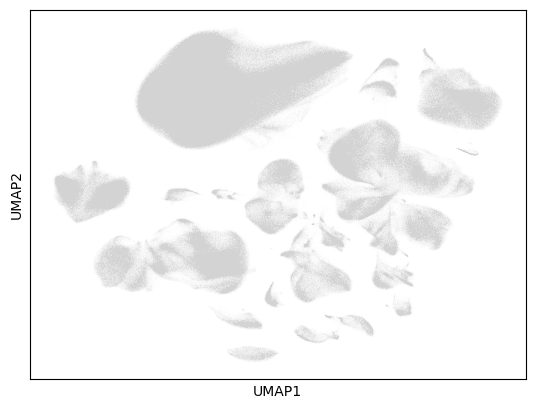

/var/tmp/pbs.404003.pbs01/ipykernel_123829/1397999014.py:20: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, resolution=0.5)  # adjust resolution as needed


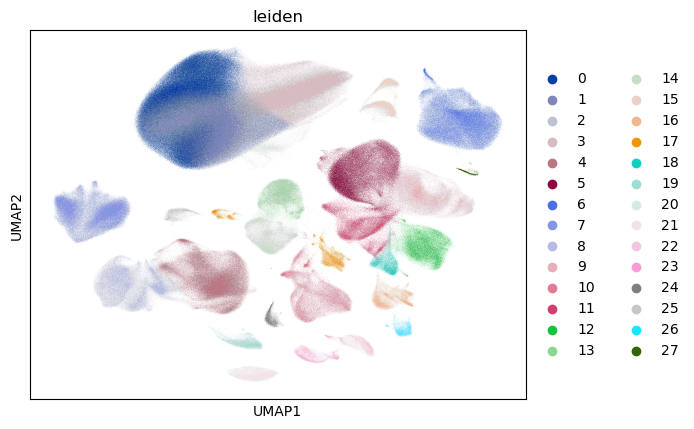

/home/znazari/cellxgene_census2025_new/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:456: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "names"] = self.var_names[global_indices]
/home/znazari/cellxgene_census2025_new/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:458: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "scores"] = scores[global_indices]
/home/znazari/cellxgene_census2025_new/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:

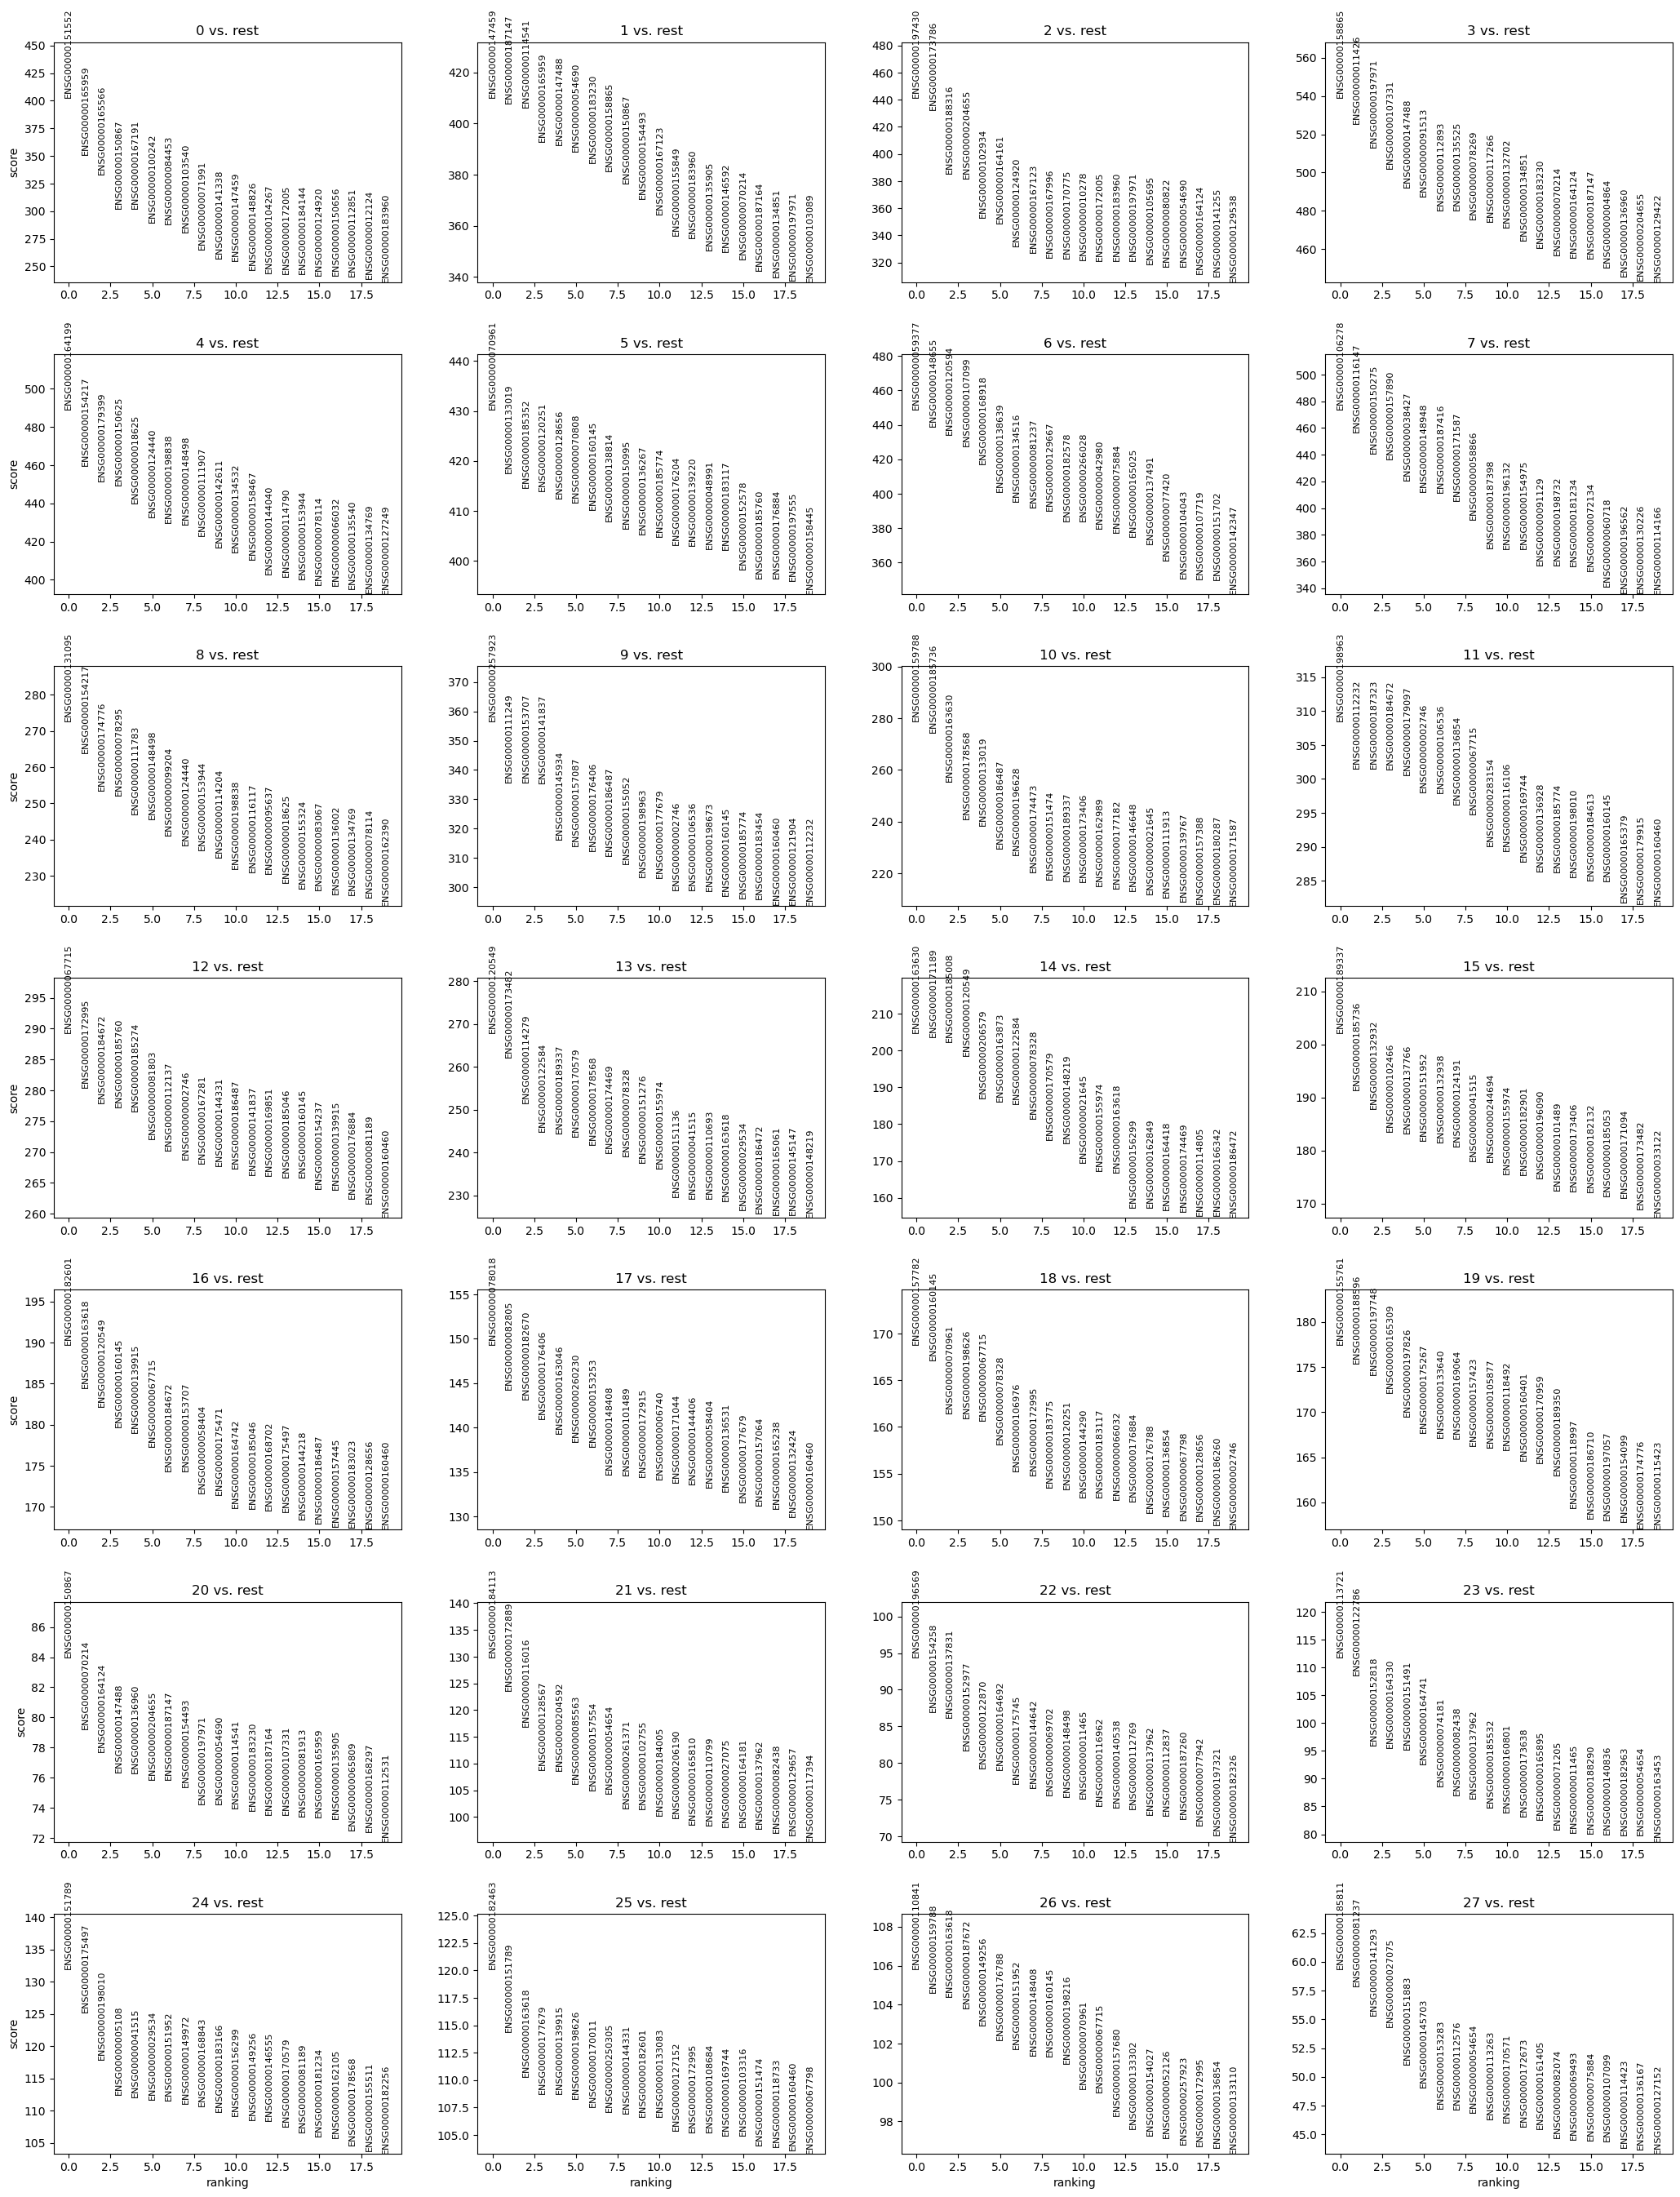

In [19]:
# ============================
# 4️⃣ Compute neighbors
# ============================
sc.pp.neighbors(
    adata,
    n_neighbors=15,  # typical range 10-30
    n_pcs=50         # use number of PCs you computed
)

# ============================
# 5️⃣ UMAP embedding
# ============================
sc.tl.umap(adata)
# Visualize without specifying genes first, just the embedding
sc.pl.umap(adata, show=True)

# ============================
# 6️⃣ Clustering (Leiden)
# ============================
sc.tl.leiden(adata, resolution=0.5)  # adjust resolution as needed
sc.pl.umap(adata, color='leiden', show=True)

# ============================
# 7️⃣ Marker genes per cluster
# ============================
sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')  # or 'wilcoxon'
sc.pl.rank_genes_groups(adata, n_genes=20, sharey=False)


In [17]:
#print(adata.X[:5, :5].A), # your adata.X matrix is stored in a sparse format, specifically a Compressed Sparse Row (CSR) matrix

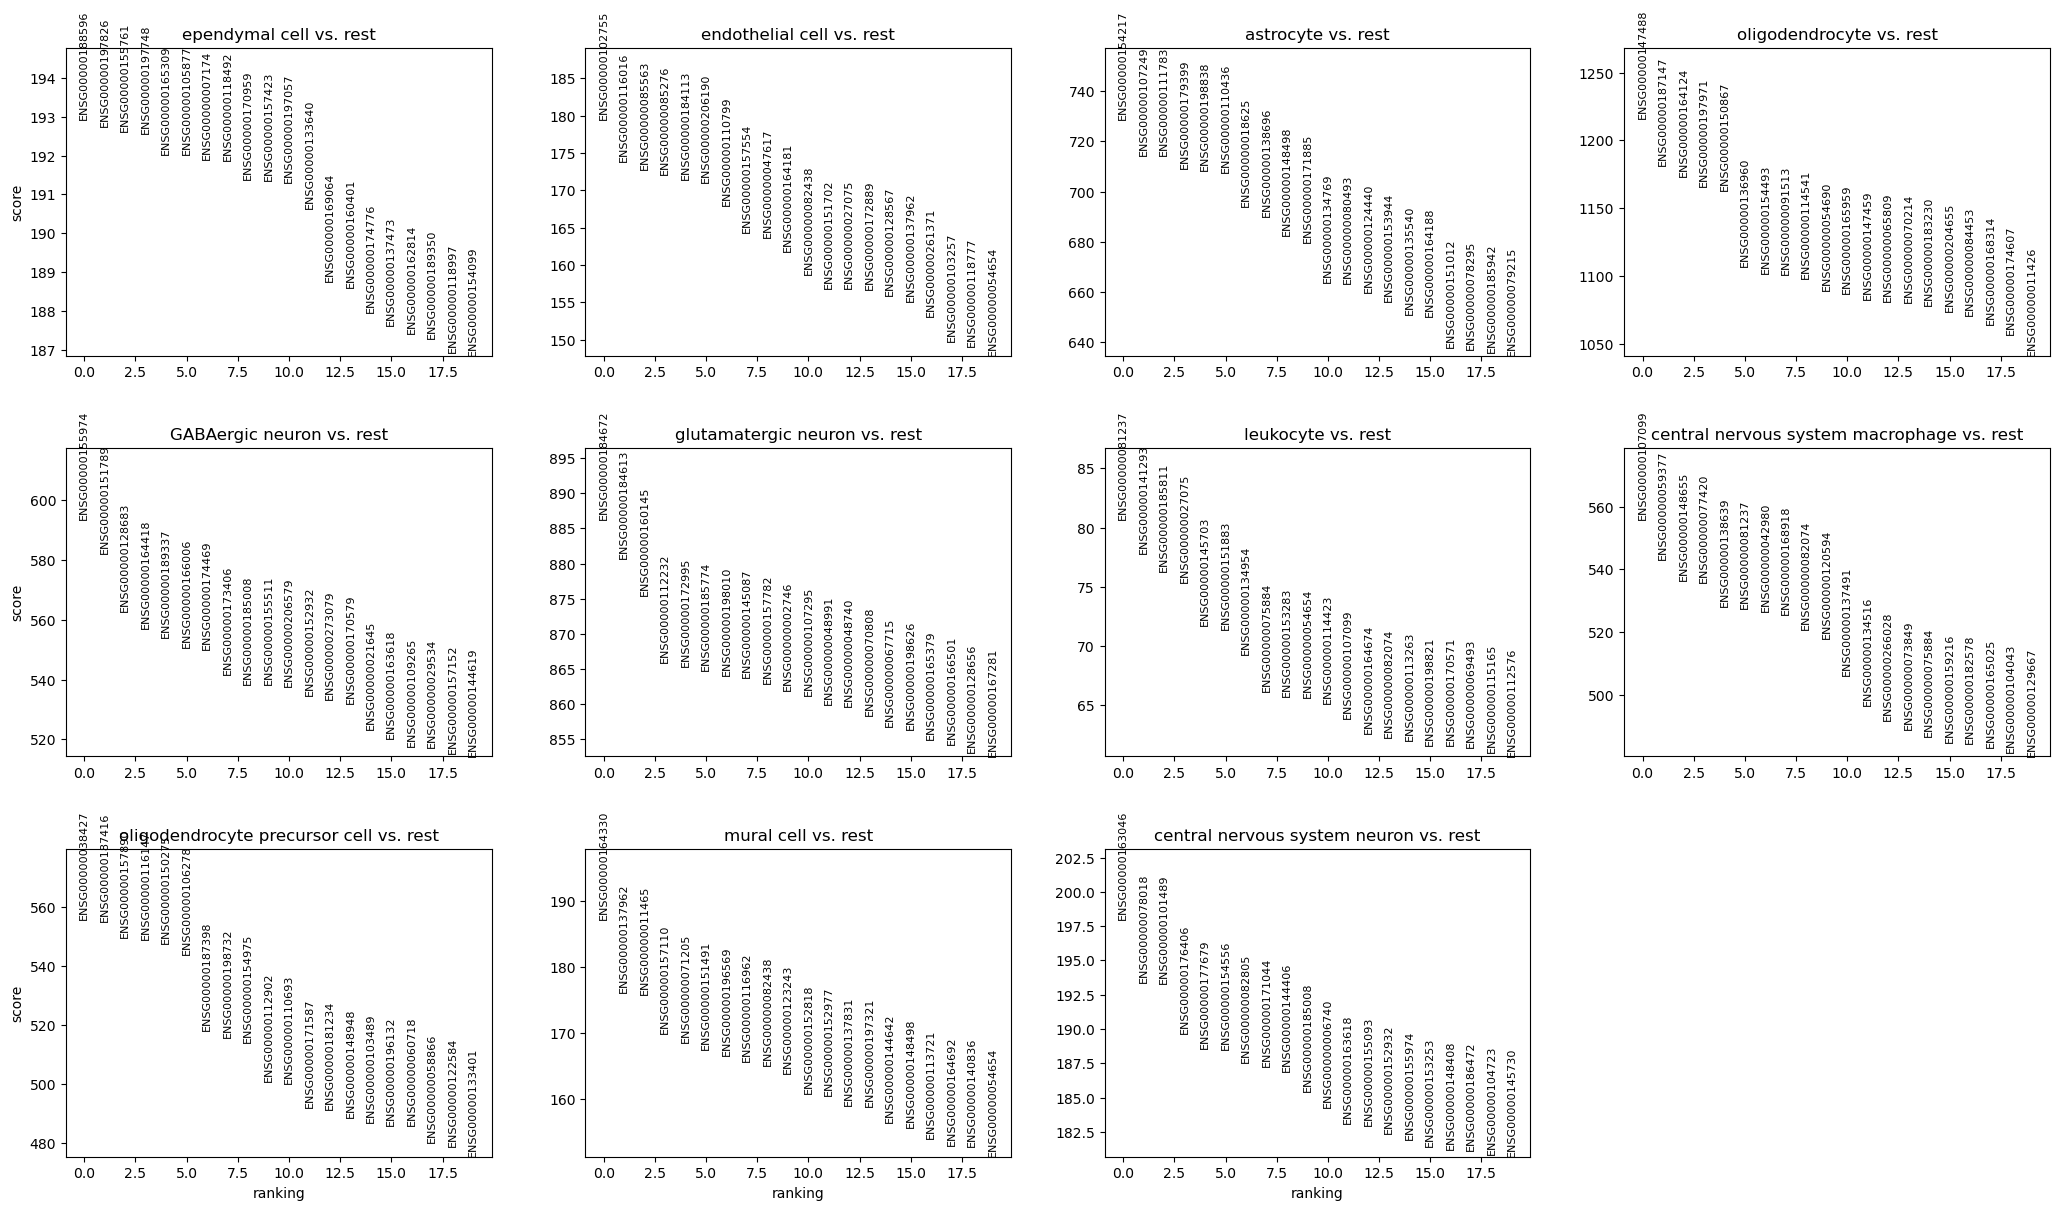

In [9]:
# Rank genes for each cluster or cell type
sc.tl.rank_genes_groups(adata_hvg, groupby='cell_type', method='wilcoxon')
sc.pl.rank_genes_groups(adata_hvg, n_genes=20, sharey=False)


In [4]:
# Build the neighborhood graph

sc.pp.neighbors(adata_hvg, n_pcs=30)


In [5]:
# Run Leiden clustering
sc.tl.leiden(adata_hvg, resolution=1.0)


/var/tmp/pbs.403180.pbs01/ipykernel_140370/3258789173.py:2: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata_hvg, resolution=1.0)


In [6]:
# where my cluster is 
adata_hvg.obs['leiden']


barcodekey
Set10_C1-AAACCCACATCACGGC     4
Set10_C1-AAACCCAGTAGCACAG     2
Set10_C1-AAACCCAGTATGTCCA     3
Set10_C1-AAACCCAGTCCAGAAG     0
Set10_C1-AAACCCATCCACGTAA     5
                             ..
set7A_2-TTTGTTGTCAAGAGTA      1
set7A_2-TTTGTTGTCACTCTTA     10
set7A_2-TTTGTTGTCAGTGCGC      6
set7A_2-TTTGTTGTCGCCTATC      7
set7A_2-TTTGTTGTCTCTAGGA      4
Name: leiden, Length: 2096155, dtype: category
Categories (37, object): ['0', '1', '2', '3', ..., '33', '34', '35', '36']

In [7]:
# Compute NMI with cell_type and disease

from sklearn.metrics import normalized_mutual_info_score
import pandas as pd

df_pca = adata_hvg.obs[['leiden', 'cell_type', 'disease']].copy()

# NMI with cell type
nmi_celltype = normalized_mutual_info_score(df_pca['leiden'], df_pca['cell_type'])
print("NMI Leiden vs Cell Type (PCA):", nmi_celltype)

# NMI with disease
nmi_disease = normalized_mutual_info_score(df_pca['leiden'], df_pca['disease'])
print("NMI Leiden vs Disease (PCA):", nmi_disease)


NMI Leiden vs Cell Type (PCA): 0.6800678574671087
NMI Leiden vs Disease (PCA): 0.010480566698818566


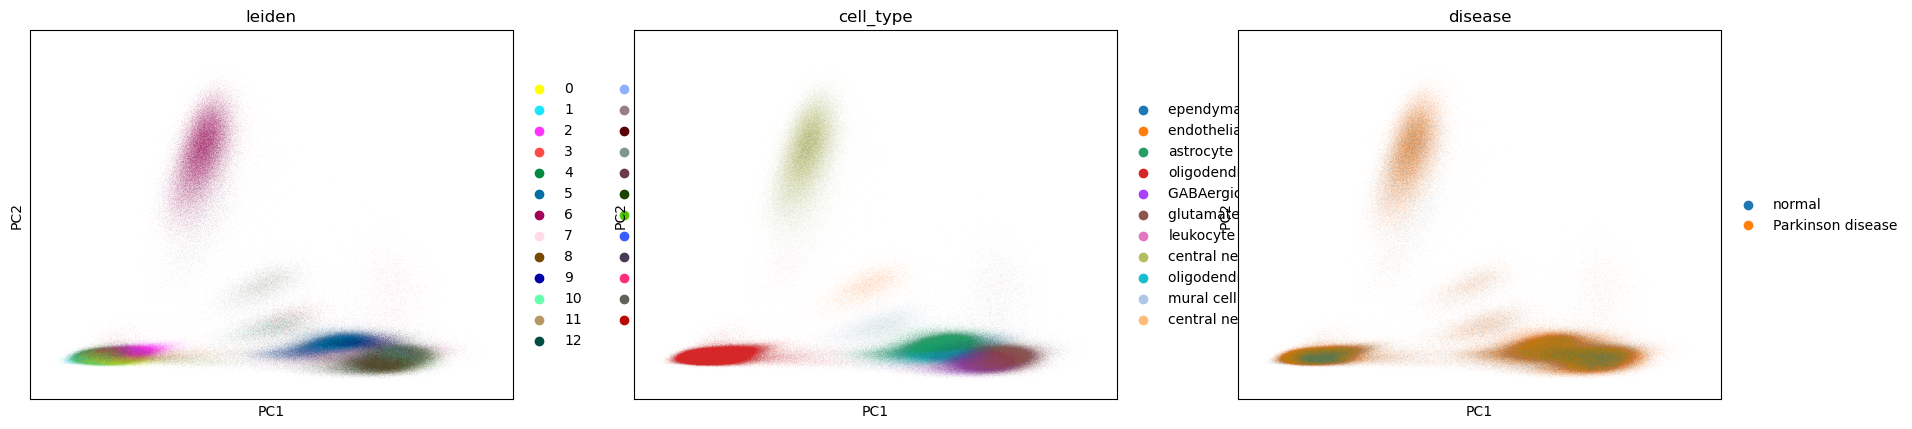

In [8]:
# Plot 

sc.pl.pca_scatter(adata_hvg, color=['leiden', 'cell_type', 'disease'])
